# Experiments with the MNIST dataset - developing and implementing 4 different algorithms from scratch

This notebook will develop, implement and test four algorithms from scratch in Python for classifying the MNIST dataset:
+ Generative model
+ Nearest neighbour
+ One vs All Logistic Regression
+ Neural Networks, 2 ways of doing this

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import classification_report, confusion_matrix
import sys
import time
import itertools

import warnings
warnings.filterwarnings("ignore")

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

## Load the data

In [2]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

In [3]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [4]:
## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

Training dataset dimensions:  (60000, 784)
Number of training labels:  60000
Testing dataset dimensions:  (10000, 784)
Number of testing labels:  10000


In [5]:
## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test set distribution:
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [6]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## Visualise the data

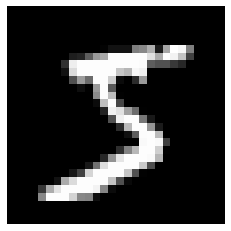

Label 5


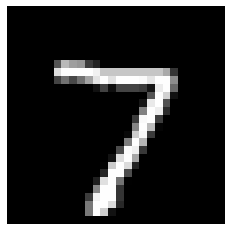

Label 7


In [7]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"): 
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    return

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
vis_image(0, "test")

# 1. Fit a Gaussian generative model to the training data 

In [8]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    
    for label in range(k):
        indices = (y == label)
        mu[label] = np.mean(x[indices,:], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=False, bias=1)
        pi[label] = float(sum(indices))/float(len(y))
    
    b = np.eye(d, dtype = float)
    a = 4000*b
    sigma = sigma+a

    return mu, sigma, pi

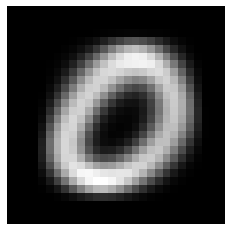

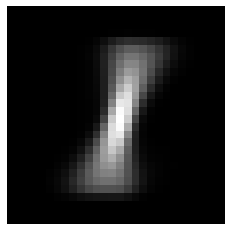

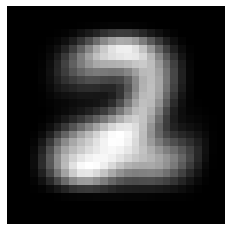

In [9]:
#ry out the function, use displaychar to visualise the means of the 
#Gaussians for the first three digits
mu, sigma, pi = fit_generative_model(train_data, train_labels)
show_digit(mu[0])
show_digit(mu[1])
show_digit(mu[2])

## Make predictions on the test data

In [10]:
# Compute log Pr(label|image) for each [test image,label] pair.
k = 10
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
        score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions_gen = np.argmax(score, axis=1)
# tally up score
errors_gen = np.sum(predictions_gen != test_labels)
print("The model makes " + str(errors_gen) + " errors out of 10000")      

The model makes 431 errors out of 10000


In [11]:
print(classification_report(predictions_gen, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1006
           1       0.99      0.95      0.97      1192
           2       0.93      0.97      0.95       990
           3       0.95      0.95      0.95      1000
           4       0.96      0.98      0.97       958
           5       0.94      0.97      0.95       859
           6       0.97      0.97      0.97       964
           7       0.94      0.97      0.95       994
           8       0.93      0.92      0.93       988
           9       0.96      0.92      0.94      1049

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



The performance for the Gaussian generative model is good, with a 96% accuracy. As the classification report shows, the model had more difficulty with classifying certain digits; for example, 8 and 9 have a lower F1 score compared to the other digits.

# 2. Nearest Neighbour

Given that for each item for which the label is being predicted, distance from all of the items in the training set needs to be calculated, nearest neighbour o the entirety of the MNIST data set will take a long time. Therefore, for this algorithm, a subset of the data will be used, which consists of a train set of 7,500 and test set of 1,000. The time taken to conduct this will be compared to the time taken by SKLearn methods.

In [12]:
#load train set
train_data = np.load('MNIST/train_data.npy')
train_labels = np.load('MNIST/train_labels.npy')

#load test set
test_data = np.load('MNIST/test_data.npy')
test_labels = np.load('MNIST/test_labels.npy')

In [13]:
#dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

Training dataset dimensions:  (7500, 784)
Number of training labels:  7500
Testing dataset dimensions:  (1000, 784)
Number of testing labels:  1000


In [14]:
#compute number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 750, 1: 750, 2: 750, 3: 750, 4: 750, 5: 750, 6: 750, 7: 750, 8: 750, 9: 750}
Test set distribution:
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}


## Squared Euclidean distance

In [15]:
## Computes squared Euclidean distance between two vectors.
def squared_dist(x,y):
    return np.sum(np.square(x-y))

## Computing nearest neighbours

In [16]:
#takes a vector x and returns index of its nearest neighbor in train_data
def find_NN(x):
    # Compute distances from x to every row in train_data
    distances = [squared_dist(x,train_data[i,]) for i in range(len(train_labels))]
    # Get the index of the smallest distance
    return np.argmin(distances)

#takes vector x and returns class of its nearest neighbor in train_data
def NN_classifier(x):
    # Get the index of the the nearest neighbor
    index = find_NN(x)
    # Return its class
    return train_labels[index]

## Processing the full test set

To classify each test point, the code takes a full pass over each of the 7500 training examples. Therefore, it is expected to be very slow.

Below, faster methods, obtained through SKLearn, will be used as a comparison.

In [17]:
## Predict on each test data point (and time it!)
t_before = time.time()
predictions_NN = [NN_classifier(test_data[i,]) for i in range(len(test_labels))]
t_after = time.time()

## Compute the error
err_positions = np.not_equal(predictions_NN, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier: ", error)
print("Classification time (seconds): ", t_after - t_before)

Error of nearest neighbor classifier:  0.046
Classification time (seconds):  185.00969815254211


In [18]:
print(classification_report(predictions_NN, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       103
           1       1.00      0.94      0.97       106
           2       0.94      0.96      0.95        98
           3       0.91      0.97      0.94        94
           4       0.97      0.94      0.96       103
           5       0.98      0.93      0.96       105
           6       0.99      0.99      0.99       100
           7       0.94      0.93      0.94       101
           8       0.92      0.98      0.95        94
           9       0.90      0.94      0.92        96

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



## SKLearn alternatives

In [19]:
from sklearn.neighbors import BallTree

## Build nearest neighbor structure on training data
t_before = time.time()
ball_tree = BallTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))
ball_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Compute the error
err_positions = np.not_equal(ball_tree_predictions, test_labels)
error_ball_tree = float(np.sum(err_positions))/len(test_labels)
print("Error of nearest neighbor classifier: ", error_ball_tree)

## Verify that the predictions are the same
print("Ball tree produces same predictions as above? ", np.array_equal(predictions_NN, ball_tree_predictions))

Time to build data structure (seconds):  1.1567909717559814
Time to classify test set (seconds):  16.782490015029907
Error of nearest neighbor classifier:  0.046
Ball tree produces same predictions as above?  True


In [20]:
print(classification_report(ball_tree_predictions, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       103
           1       1.00      0.94      0.97       106
           2       0.94      0.96      0.95        98
           3       0.91      0.97      0.94        94
           4       0.97      0.94      0.96       103
           5       0.98      0.93      0.96       105
           6       0.99      0.99      0.99       100
           7       0.94      0.93      0.94       101
           8       0.92      0.98      0.95        94
           9       0.90      0.94      0.92        96

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



In [21]:
from sklearn.neighbors import KDTree

## Build nearest neighbor structure on training data
t_before = time.time()
kd_tree = KDTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(kd_tree.query(test_data, k=1, return_distance=False))
kd_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Compute the error
err_positions = np.not_equal(kd_tree_predictions, test_labels)
error_kd_tree = float(np.sum(err_positions))/len(test_labels)
print("Error of nearest neighbor classifier: ", error_kd_tree)

## Verify that the predictions are the same
print("KD tree produces same predictions as above? ", np.array_equal(predictions_NN, kd_tree_predictions))

Time to build data structure (seconds):  0.8794682025909424
Time to classify test set (seconds):  23.204397201538086
Error of nearest neighbor classifier:  0.046
KD tree produces same predictions as above?  True


In [22]:
print(classification_report(kd_tree_predictions, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       103
           1       1.00      0.94      0.97       106
           2       0.94      0.96      0.95        98
           3       0.91      0.97      0.94        94
           4       0.97      0.94      0.96       103
           5       0.98      0.93      0.96       105
           6       0.99      0.99      0.99       100
           7       0.94      0.93      0.94       101
           8       0.92      0.98      0.95        94
           9       0.90      0.94      0.92        96

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



# 3. One-vs-All Logistic Regression

Mulitple one-vs-all logistic regression models will be used to build a mulit-class classifier. Since there are 10 classes, 10 separate logisitc regression classifiers will be trained. To ensure efficient training, the code must be well-vectorised.

In [23]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [24]:
def sigmoid(z):
    sigmoid = 1 / (1 + np.exp(-z))
    return sigmoid

def compute_cost(theta, X, y, lambda_coef):
    m = X.shape[0]
    # Do matrix multiplication with numpy.dot
    h_theta = sigmoid(np.dot(X, theta))
    term1 = np.dot(-y.T, np.log(h_theta))
    term2 = np.dot((1 - y).T, np.log(1 - h_theta))
    # Exclude theta_0!!!
    reg_term = (lambda_coef / (2 * m)) * np.sum(np.square(theta[1:]))
    cost = (np.sum(term1 - term2) / m) + reg_term
    return cost

def compute_gradient(theta, X, y, lambda_coef):
    m = X.shape[0]
    h_theta = sigmoid(np.dot(X, theta))
    # Exclude theta_0!!!
    reg_term = (lambda_coef / m) * (theta[1:])
    gradient = (1 / m) * np.dot(X.T, (h_theta - y))
    gradient[1:] = gradient[1:] + reg_term
    return gradient

A one-vs-all classification will be implemented by training multiple regularized logistic regression classifiers, one for each of the K
classes in the dataset. In the handwritten digits dataset, K=10, but the code should work for any value of K

In [25]:
from scipy.optimize import minimize

def one_vs_all(X, y, K, lambda_coef):
    #trains K logistic regression classifiers and returns eac of these 
    #classifiers in an array thetas where ith row corresponds to classifier
    #for label i"""
    
    # Get the number of training examples, m.
    m = X.shape[0]
    # Get the number of features, n.
    n = X.shape[1]

    # Create an array of shape(K, n+1) for each K class,
    # i.e. for each digit 0 to 9.
    Thetas = np.zeros((K, n+1))
    
    #Insert a 1's column to X.
    X = np.insert(X, 0, 1, axis=1)

    # Train each classifier independently from 1 to K.
    for i in range(0, K):
        print("Training the classifier for class k = {}...".format(i))
        # Take into account that class "10" corresponds to "0".
        if i == 0:
            x = 10
        else:
            x = i
        # Initialize theta.
        theta = np.zeros((n+1, 1))
        y_i = np.array([1 if class_k == x else 0 for class_k in y])
        y_i = np.reshape(y_i, (m, ))

        # Minimize the cost function.
        # Various methods were tested. It was found that 'TNC'
        # is faster and gives very good results.
        res = minimize(fun=compute_cost, x0=theta, args=(X, y_i, lambda_coef),
                       method='TNC', jac=compute_gradient)
        Thetas[i, :] = res.x
    print("Training is completed!")
    return Thetas

In [26]:
import warnings
warnings.filterwarnings('ignore')

Thetas = one_vs_all(train_data, train_labels, 10, 0)

Training the classifier for class k = 0...
Training the classifier for class k = 1...
Training the classifier for class k = 2...
Training the classifier for class k = 3...
Training the classifier for class k = 4...
Training the classifier for class k = 5...
Training the classifier for class k = 6...
Training the classifier for class k = 7...
Training the classifier for class k = 8...
Training the classifier for class k = 9...
Training is completed!


## One-vs-All Predictions

In [27]:
# Create a prediction function
#predicts if label is 0 or 1 using the learned logistic regression parameters thetas
def predict_one_vs_all(X, theta):
    #Insert a 1's column to X.
    X = np.insert(X, 0, 1, axis=1) # shape(5000, 401)
    p = sigmoid(np.dot(X, theta.T)) # shape(5000, 10)
    p_argmax = np.argmax(p, axis=1) # shape(5000,)
    # Replace 0's with 10's to fix that a “0” digit is labeled as “10”.
    p_argmax = [10 if x == 0 else x for x in p_argmax]
    return p_argmax

predictions_onevsall = predict_one_vs_all(test_data, Thetas)
correct = np.sum(predictions_onevsall == test_labels.reshape(-1))
total = len(predictions_onevsall)

In [28]:
print(classification_report(predictions_onevsall, test_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.98      0.96      0.97      1160
           2       0.88      0.79      0.83      1155
           3       0.91      0.83      0.87      1104
           4       0.93      0.92      0.92       995
           5       0.87      0.68      0.76      1133
           6       0.96      0.80      0.87      1150
           7       0.92      0.90      0.91      1051
           8       0.88      0.69      0.77      1231
           9       0.89      0.88      0.88      1021

    accuracy                           0.82     10000
   macro avg       0.82      0.74      0.78     10000
weighted avg       0.91      0.82      0.86     10000



The accuracy score is fairly low. This is at least in part because logistic regression cannot form more complex hypotheses as it is only a linear classifier. More features can be added (such as polynomial features), but that can be very expensive to train.

# 4a. Neural Network version 1

The neural network will be able to represent complex models that form non-linear hypotheses. 

The goal is to implement the feedforward propagation algorithm to use the weights for prediction. Then the backpropagation algorithm will be created for learning the neural network parameters. 

In [29]:
## Load the training set
train_data = np.float32(load_mnist_images('train-images-idx3-ubyte.gz'))
train_labels = np.int32(load_mnist_labels('train-labels-idx1-ubyte.gz'))

## Load the testing set
test_data = np.float32(load_mnist_images('t10k-images-idx3-ubyte.gz'))
test_labels = np.int32(load_mnist_labels('t10k-labels-idx1-ubyte.gz'))

In [30]:
# normalise the data for gradient manageability
X_train = train_data / 255
X_test = test_data /255

# one-hot encode labels
digits = 10
examples_train = train_labels.shape[0]
train_labels = train_labels.reshape(1, examples_train)
Y_new_train = np.eye(digits)[train_labels.astype('int32')]
Y_new_train = Y_new_train.T.reshape(digits, examples_train)

examples_test = test_labels.shape[0]
test_labels = test_labels.reshape(1, examples_test)
Y_new_test = np.eye(digits)[test_labels.astype('int32')]
Y_new_test = Y_new_test.T.reshape(digits, examples_test)

# split, reshape, shuffle
m = 60000
X_train = X_train.T
X_test = X_test.T
y_train = Y_new_train
y_test = Y_new_test
shuffle_index = np.random.permutation(m)
X_train, y_train = X_train[:, shuffle_index], y_train[:, shuffle_index]

In [31]:
# reserve the last 10000 training examples for validation
X_train, val_data = X_train[:,:-10000], X_train[:,-10000:]
y_train, val_labels = y_train[:,:-10000], y_train[:,-10000:]

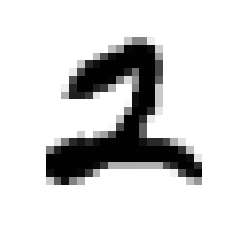

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
#sanity check labels and images still aligned
i = 12
plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
y_train[:,i]

#### Forward propogation

In [33]:
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

def compute_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

def feed_forward(X, params):

    cache = {}

    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    cache["A1"] = sigmoid(cache["Z1"])
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)

    return cache

#### Backward propogation

In [34]:
def back_propagate(X, Y, params, cache):

    dZ2 = cache["A2"] - Y
    dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

#### Build and train

Epoch 24
Train cost: 0.0043334216933703954
Val cost: 0.09564164791545221


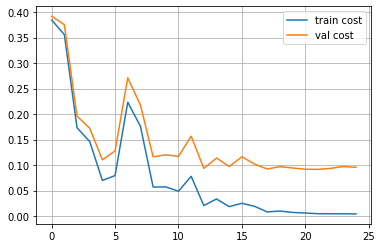

In [35]:
from IPython.display import clear_output

np.random.seed(138)
train_log1 = []
val_log1 = []

# hyperparameters
n_x = X_train.shape[0]
n_h = 64
learning_rate = 4
beta = .9
batch_size = 128
batches = -(-m // batch_size)

# initialisation
params = { "W1": np.random.randn(n_h, n_x) * np.sqrt(1. / n_x),
           "b1": np.zeros((n_h, 1)) * np.sqrt(1. / n_x),
           "W2": np.random.randn(digits, n_h) * np.sqrt(1. / n_h),
           "b2": np.zeros((digits, 1)) * np.sqrt(1. / n_h) }

V_dW1 = np.zeros(params["W1"].shape)
V_db1 = np.zeros(params["b1"].shape)
V_dW2 = np.zeros(params["W2"].shape)
V_db2 = np.zeros(params["b2"].shape)

# train
for i in range(25):

    #shuffle training set
    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    y_train_shuffled = y_train[:, permutation]

    for j in range(batches):

        #get mini batch
        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        y = y_train_shuffled[:, begin:end]
        m_batch = end - begin

        #forward and backward
        cache = feed_forward(X, params)
        grads = back_propagate(X, y, params, cache)

        #with momentum
        V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])
        V_db1 = (beta * V_db1 + (1. - beta) * grads["db1"])
        V_dW2 = (beta * V_dW2 + (1. - beta) * grads["dW2"])
        V_db2 = (beta * V_db2 + (1. - beta) * grads["db2"])

        #gradient descent
        params["W1"] = params["W1"] - learning_rate * V_dW1
        params["b1"] = params["b1"] - learning_rate * V_db1
        params["W2"] = params["W2"] - learning_rate * V_dW2
        params["b2"] = params["b2"] - learning_rate * V_db2

    #forward pass on training set to compute loss with learned parameters so far
    cache = feed_forward(X_train, params)
    train_cost = compute_loss(y_train, cache["A2"])
    
    #forward pass on test set to compute loss with paramters learned from 
    #training set
    cache = feed_forward(val_data, params)
    val_cost = compute_loss(val_labels, cache["A2"])
    #print("Epoch {}: training cost = {}, validation cost = {}".format(i+1 ,train_cost.round(4), val_cost.round(4)))   
    
    train_log1.append(train_cost)
    val_log1.append(val_cost)
    
    clear_output()
    print("Epoch", i)
    print("Train cost:", train_log1[-1])
    print("Val cost:", val_log1[-1])
    plt.plot(train_log1, label = 'train cost')
    plt.plot(val_log1, label = 'val cost')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

In [36]:
#evaluate performance with test set
from sklearn.metrics import classification_report, confusion_matrix

#forward pass over test set using paramters learned from model building
cache = feed_forward(X_test, params)

#use cache generated to make predictions of labels
predictions = np.argmax(cache["A2"], axis=0)

#actual test set labels
labels = np.argmax(y_test, axis=0)

print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       992
           1       0.99      0.99      0.99      1141
           2       0.97      0.98      0.97      1023
           3       0.96      0.98      0.97       996
           4       0.97      0.98      0.97       972
           5       0.97      0.95      0.96       911
           6       0.97      0.97      0.97       959
           7       0.98      0.97      0.98      1036
           8       0.96      0.98      0.97       954
           9       0.97      0.96      0.97      1016

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# 4b. Neural Network (MLP) version 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
## Load the training set
train_data = np.float32(load_mnist_images('train-images-idx3-ubyte.gz'))
train_labels = np.int32(load_mnist_labels('train-labels-idx1-ubyte.gz'))

## Load the testing set
test_data = np.float32(load_mnist_images('t10k-images-idx3-ubyte.gz'))
test_labels = np.int32(load_mnist_labels('t10k-labels-idx1-ubyte.gz'))

In [5]:
# normalise x
train_data = train_data / 255.
test_data = test_data / 255.

#split into train and validation
train_data, val_data = train_data[:-10000], train_data[-10000:]
train_labels, val_labels = train_labels[:-10000], train_labels[-10000:]

#flatten the data       
train_data = train_data.reshape([train_data.shape[0], -1])
val_data = val_data.reshape([val_data.shape[0], -1])
test_data = test_data.reshape([test_data.shape[0], -1])

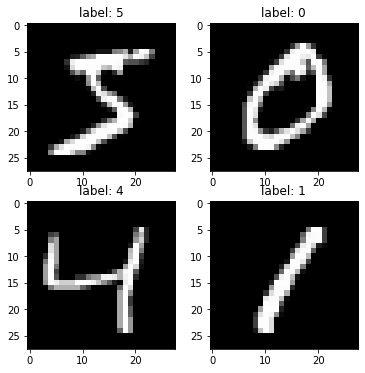

In [6]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("label: %i"%train_labels[i])
    plt.imshow(train_data[i].reshape([28,28]),cmap='gray');

## Main class 

This main class layer will do forward and backward passes. Each layer will be capable of performing: (1) processing of input to get output; (2) propagating gradients through iteself. Some layers also will have learnable paramters that they can update during the backward pass

In [7]:
class Layer:
    def __init__(self):
        #initialise layer parameters (if any)
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        #Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        # backpropagation step through the layer, with respect to the given input.
        #To compute loss gradients w.r.t input, apply chain rule:
        #d loss / d x  = (d loss / d layer) * (d layer / d x)
        # gradient of a dummy layer is grad_output
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

## Nonlinearity layer

Simplest layer, which applies a nonlinearity to each element of the network. 

The ReLU layer simply applies elementwise rectified linear unit to all inputs.

In [8]:
class ReLU(Layer):
    def __init__(self):
        #ReLU layer applies elementwise rectified linear unit to all inputs
        pass
    
    def forward(self, input):
        #Apply elementwise ReLU to [batch, input_units] matrix
        return np.maximum(input, np.zeros(input.shape))
    
    def backward(self, input, grad_output):
        #Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output*relu_grad       

## Dense layer

Unlike nonlinearity, a dense layer has something to learn; it applies affine transformation

f(X) = W.X + b

+ X is an object-feature matrix of shape [batch_size, num_features]
+ W is a weight matrix [num_features, num_outputs]
+ b is a vector of num_outputs biases

W and b are initialised during layer creation and updated each time backward is called

In [9]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        #Aa layer which performs a learned affine transformation: f(x) = <W*x> + b
        self.learning_rate = learning_rate
        
        # initialise weights with small random numbers (normal initialisation), 
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        #Perform an affine transformation: f(x) = <W*x> + b
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T) #<your code here> df/dx = df/ds * W.T and here df/ds = grad_output
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output) #<your code here>
        grad_biases = np.sum(grad_output, axis = 0) #<your code here>
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

## Loss function


With the expression for crossentropy as a function of softmax logits:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

This can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

This Log-softmax is better than naive log(softmax) as it:
* Has better numerical stability
* Is easier to get the derivative right
* Is marginally faster to compute

Therefore, log-softmax will be used throughout the computation so do not need to estimate probabilities.

In [10]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    #Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    #Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

## Full network

In [11]:
#define network as list of layers, here using 3 layers
network = []
network.append(Dense(train_data.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [12]:
#forward function to compute activations of all network layers by applying them sequentially
#returns a list of activations for each layer, which corresponds to network logits
def forward(network, X):
    activations = []
    input = X
    
    for layer in network:
        output = layer.forward(input)
        activations.append(output)
        input = output
        
    assert len(activations) == len(network)
    return activations

In [13]:
#predict function to compute network predictions
def predict(network, X):
    logits = forward(network, X)[-1]
    return logits.argmax(axis = -1)

In [14]:
#train function that trains the network on a given batch of X and y;
#first runs forwards to get all layer activations, then run backwards
def train(network, X, y):
    #get layer activations
    layer_act = forward(network, X)
    layer_inputs = [X] + layer_act #layer_input[i] is an input for network[i]
    logits = layer_act[-1]
    
    #compute loss and initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
    
    #propagate gradients through network
    #grad_output = loss_grad
    layer_inputs = layer_inputs[:-1]
    for input, layer in zip(layer_inputs[::-1], network[::-1]):
        loss_grad = layer.backward(input, loss_grad)
        
    return np.mean(loss)

## Training

Split data into minibatches and feed into network and update weights.

In [15]:
from numpy import random
def iterate_minibatches(X, y, batch_size):
    random_idxs = random.choice(len(y), len(y), replace=False)
    X_shuffled = X[random_idxs,:]
    y_shuffled = y[random_idxs]
    mini_batches = [(X_shuffled[i:i+batch_size,:], y_shuffled[i:i+batch_size]) for
                   i in range(0, len(y), batch_size)]
    return mini_batches

In [16]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9794


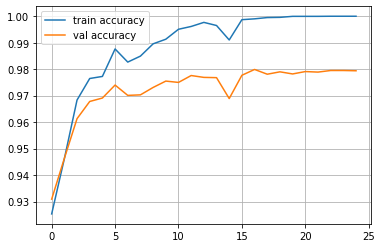

In [17]:
for epoch in range(25):
    mini_batches = iterate_minibatches(train_data, train_labels, 32)
    for mini_batch in mini_batches:
        x_batch = mini_batch[0]
        y_batch = mini_batch[1]
        train(network, x_batch, y_batch)
        
    train_log.append(np.mean(predict(network, train_data) == train_labels))
    val_log.append(np.mean(predict(network, val_data) == val_labels))
    
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])
    plt.plot(train_log, label = 'train accuracy')
    plt.plot(val_log, label = 'val accuracy')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

In [18]:
#evaluate performance with test set
from sklearn.metrics import classification_report, confusion_matrix

predictions = predict(network, test_data)

print(classification_report(predictions, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       990
           1       0.99      0.99      0.99      1144
           2       0.97      0.98      0.98      1020
           3       0.98      0.97      0.98      1019
           4       0.98      0.98      0.98       986
           5       0.97      0.98      0.97       883
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1022
           8       0.97      0.98      0.97       968
           9       0.98      0.98      0.98      1010

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## Further improvement attempts

### Deep network (5 layers) with normal and Xavier initialisation

In [19]:
class Dense1(Layer):
    def __init__(self, input_units, output_units, initializer='normal', learning_rate=0.1):
        self.learning_rate = learning_rate

        # initialize weights with small random numbers. 
        if initializer == 'normal':
            self.weights = np.random.randn(input_units, output_units) * 0.01
        elif initializer == 'xavier':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(2 / (input_units + output_units))
        else:
            raise ValueError('Wrong initializer parameter')
        self.biases = np.zeros(output_units)
       
    
    def forward(self,input):
        return input.dot(self.weights) + self.biases
    
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        grad_input = grad_output.dot(self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [20]:
def build_and_train1(initializer, lr, n_epochs):
    
    print('\nTraining of Deep Network with initializer = {} and lr = {} for n_epochs = {}'.format(initializer, lr, n_epochs))
    
    network = []
    network.append(Dense1(train_data.shape[1], 100, initializer, lr))
    network.append(ReLU())
    network.append(Dense1(100, 200, initializer, lr))
    network.append(ReLU())
    network.append(Dense1(200, 300, initializer, lr))
    network.append(ReLU())
    network.append(Dense1(300, 400, initializer, lr))
    network.append(ReLU())
    network.append(Dense1(400, 10, initializer, lr))
    
    train_log = []
    val_log = []

    for epoch in range(n_epochs):
        mini_batches = iterate_minibatches(train_data, train_labels, 32)
        for mini_batch in mini_batches:
            x_batch = mini_batch[0]
            y_batch = mini_batch[1]
            train(network, x_batch, y_batch)

        train_log.append(np.mean(predict(network, train_data)==train_labels))
        val_log.append(np.mean(predict(network,val_data)==val_labels))    
        
    return train_log, val_log

def display_learning_curve1(ax, train_log, val_log, initializer, lr):
        
    ax.plot(train_log,label='train accuracy')
    ax.plot(val_log,label='val accuracy')
    ax.set_ylim(0.86, 1)
    ax.set_title('initializer = {}, lr = {}'.format(initializer, lr), fontsize=14)
    ax.text(0.5, 0.2, 'train acc = {:6.4f}\n   val acc = {:6.4f}'.format(train_log[-1], val_log[-1]),
            ha='left', va='bottom', fontsize=14, transform=ax.transAxes)
    ax.grid()


Training of Deep Network with initializer = normal and lr = 0.07 for n_epochs = 25

Training of Deep Network with initializer = normal and lr = 0.1 for n_epochs = 25

Training of Deep Network with initializer = normal and lr = 0.3 for n_epochs = 25

Training of Deep Network with initializer = normal and lr = 0.5 for n_epochs = 25

Training of Deep Network with initializer = xavier and lr = 0.07 for n_epochs = 25

Training of Deep Network with initializer = xavier and lr = 0.1 for n_epochs = 25

Training of Deep Network with initializer = xavier and lr = 0.3 for n_epochs = 25

Training of Deep Network with initializer = xavier and lr = 0.5 for n_epochs = 25


/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


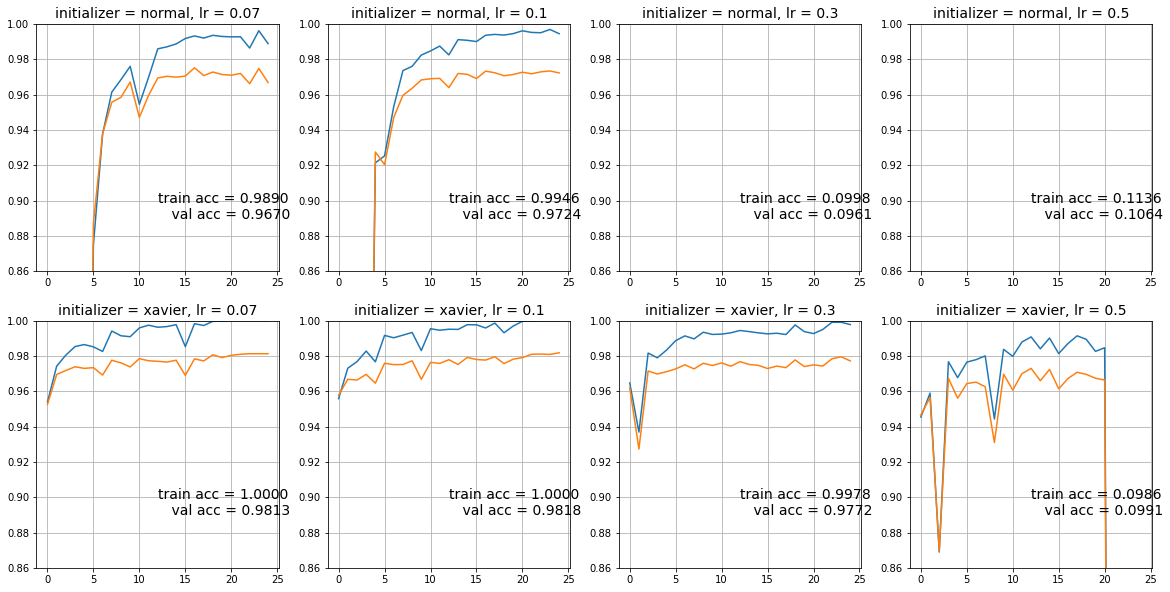

In [21]:
#as the focus here is on comparing normal and Xavier initialisation, these will be compared, however, 
#learning rate will also be varied to see how this impacts results

lrs = [0.07, 0.1, 0.3, 0.5]
initializers = ['normal', 'xavier']

n_epochs = 25

fig = plt.figure(figsize=(20, 10))
i = 0
for initializer, lr in itertools.product(initializers, lrs):
    i += 1
    train_log, val_log = build_and_train1(initializer, lr, n_epochs)

    ax = plt.subplot(len(initializers), len(lrs), i) 
    display_learning_curve1(ax, train_log, val_log, initializer, lr)

From the above plots, the best performing combination on the validation data is Xavier initialisation with a learning rate of 0.1. This combination will now be used to build a model and generate predictions of the test set.

In [22]:
initializer = 'xavier'
lr = 0.1
n_epochs = 25

network_x = []
network_x.append(Dense1(train_data.shape[1], 100, initializer, lr))
network_x.append(ReLU())
network_x.append(Dense1(100, 200, initializer, lr))
network_x.append(ReLU())
network_x.append(Dense1(200, 300, initializer, lr))
network_x.append(ReLU())
network_x.append(Dense1(300, 400, initializer, lr))
network_x.append(ReLU())
network_x.append(Dense1(400, 10, initializer, lr))

train_log_x = []
val_log_x = []

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9808


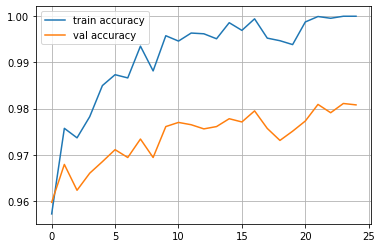

In [23]:
for epoch in range(25):
    mini_batches = iterate_minibatches(train_data, train_labels, 32)
    for mini_batch in mini_batches:
        x_batch = mini_batch[0]
        y_batch = mini_batch[1]
        train(network_x, x_batch, y_batch)
        
    train_log_x.append(np.mean(predict(network_x, train_data) == train_labels))
    val_log_x.append(np.mean(predict(network_x, val_data) == val_labels))
    
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log_x[-1])
    print("Val accuracy:", val_log_x[-1])
    plt.plot(train_log_x, label = 'train accuracy')
    plt.plot(val_log_x, label = 'val accuracy')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

In [24]:
#evaluate performance with test set
from sklearn.metrics import classification_report, confusion_matrix

predictions_x = predict(network_x, test_data)

print(classification_report(predictions_x, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1143
           2       0.98      0.98      0.98      1028
           3       0.98      0.97      0.98      1022
           4       0.97      0.98      0.98       974
           5       0.97      0.99      0.98       878
           6       0.98      0.98      0.98       954
           7       0.98      0.98      0.98      1029
           8       0.98      0.98      0.98       980
           9       0.98      0.98      0.98      1012

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### Regularisation

Implementing a version of Dense layer with L2 regularisation penalty, where when Dense layer weights are updated, gradients are adjsted to minimise 

$$ Loss = Crossentropy + \alpha \cdot \underset i \sum {w_i}^2 $$

The purpose is to mitigate overfitting in case of abundantly large number of neurons, where tuning alpha may also improve results

The network will have 3 layers

In [25]:
#given the superior performance of Xavier initialisation as shown above, this will be the default initializer
class Dense2(Layer):
    def __init__(self, input_units, output_units, initializer='xavier', learning_rate=0.1, alpha=0):
        self.learning_rate = learning_rate
        self.alpha = alpha

        # initialize weights with small random numbers. 
        if initializer == 'normal':
            self.weights = np.random.randn(input_units, output_units) * 0.01
        elif initializer == 'xavier':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(2 / (input_units + output_units))
        else:
            raise ValueError('Wrong initializer parameter')
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return input.dot(self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        grad_input = grad_output.dot(self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights - self.alpha * self.weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [26]:
def build_and_train2(lr, alpha, initializer, n_epochs):
    
    print('\nTraining with regularisation of gradients with lr = {} and alpha = {} for n_epochs = {}'.format(lr, alpha, n_epochs))
    
    network = []
    network.append(Dense2(train_data.shape[1], 100, initializer, lr, alpha))
    network.append(ReLU())
    network.append(Dense2(100, 200, initializer, lr, alpha))
    network.append(ReLU())
    network.append(Dense2(200, 10, initializer, lr, alpha))
    
    train_log = []
    val_log = []

    for epoch in range(n_epochs):
        mini_batches = iterate_minibatches(train_data, train_labels, 32)
        for mini_batch in mini_batches:
            x_batch = mini_batch[0]
            y_batch = mini_batch[1]
            train(network, x_batch, y_batch)

        train_log.append(np.mean(predict(network,train_data) == train_labels))
        val_log.append(np.mean(predict(network, val_data) == val_labels))    
        #print('epoch = {:2d}, train acc = {:6.4f}, val acc = {:6.4f}'.format(epoch, train_log[-1], val_log[-1]))
        
    return train_log, val_log

def display_learning_curve(ax, train_log, val_log, lr, alpha):
        
    ax.plot(train_log, label='train accuracy')
    ax.plot(val_log, label='val accuracy')
    ax.set_ylim(0.86, 1)
    #plt.legend(loc='best')
    ax.set_title('lr = {}, alpha = {}'.format(lr, alpha), fontsize=14)
    ax.text(0.3, 0.2, 'train acc = {:6.4f}\n   val acc = {:6.4f}'.format(train_log[-1], val_log[-1]),
            ha='left', va='bottom', fontsize=14, transform=ax.transAxes)
    ax.grid()


Training with regularisation of gradients with lr = 0.1 and alpha = 3e-05 for n_epochs = 25

Training with regularisation of gradients with lr = 0.1 and alpha = 7e-05 for n_epochs = 25

Training with regularisation of gradients with lr = 0.1 and alpha = 0.0001 for n_epochs = 25


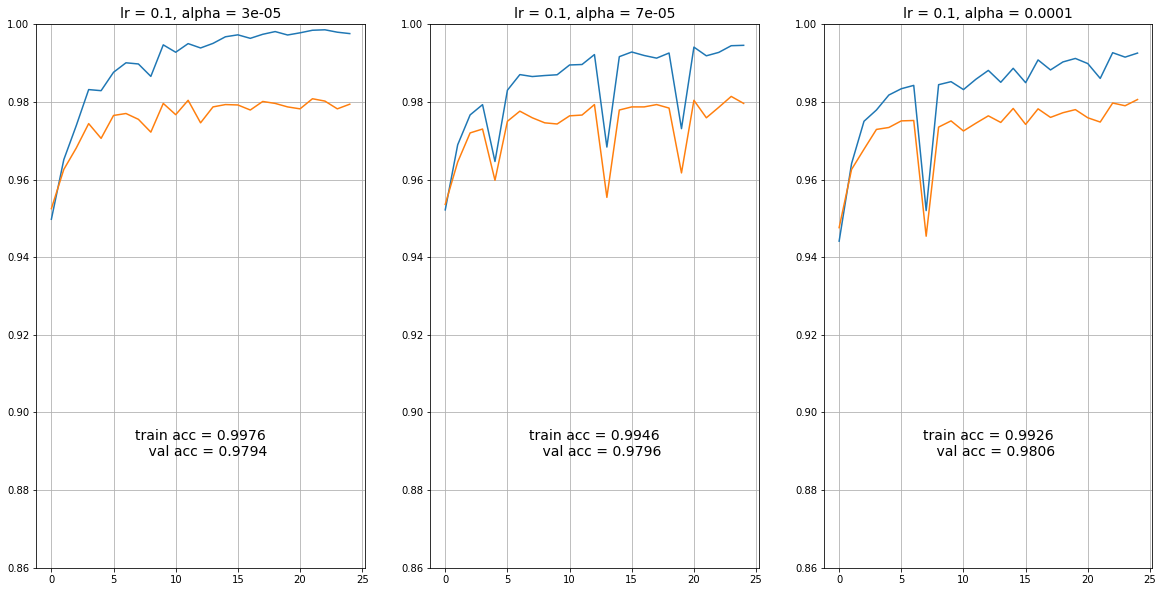

In [27]:
#for sake of training time, only the alpha value - that which determines regularisation, will
#be varied, although learning rate could also be varied to see how it impacts results
initializer = 'xavier'
lr = 0.1 
alphas = [3e-5, 7e-5, 1e-4]
n_epochs = 25

fig = plt.figure(figsize=(20, 10))
i = 0
for alpha in alphas:
    i += 1
    train_log, val_log = build_and_train2(lr, alpha, initializer, n_epochs)

    ax = plt.subplot(1, len(alphas), i) 
    display_learning_curve(ax, train_log, val_log, lr, alpha)

From the above plots, alpha with a value of 0.0001 performed best on the validation data set (although not a dramatic improvement on the performance on validation set with Xavier initialisation and no L2 regularisation, but fewer layers were used in this model - 3 vs 5 - so this may explain the very small change in validation accuracy). This alpha value will be used to build a model and predict labels on the test set.

In [34]:
initializer = 'xavier'
lr = 0.1
alpha = 0.0001

network_reg = []
network_reg.append(Dense2(train_data.shape[1], 100, initializer, lr, alpha))
network_reg.append(ReLU())
network_reg.append(Dense2(100, 200, initializer, lr, alpha))
network_reg.append(ReLU())
network_reg.append(Dense2(200, 10, initializer, lr, alpha))

train_log_reg = []
val_log_reg = []

Epoch 24
Train accuracy: 0.98946
Val accuracy: 0.9771


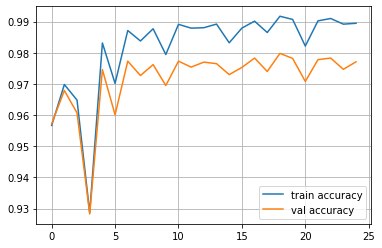

In [35]:
for epoch in range(25):
    mini_batches = iterate_minibatches(train_data, train_labels, 32)
    for mini_batch in mini_batches:
        x_batch = mini_batch[0]
        y_batch = mini_batch[1]
        train(network_reg, x_batch, y_batch)
        
    train_log_reg.append(np.mean(predict(network_reg, train_data) == train_labels))
    val_log_reg.append(np.mean(predict(network_reg, val_data) == val_labels))
    
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log_reg[-1])
    print("Val accuracy:", val_log_reg[-1])
    plt.plot(train_log_reg, label = 'train accuracy')
    plt.plot(val_log_reg, label = 'val accuracy')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

In [36]:
#evaluate performance with test set
from sklearn.metrics import classification_report, confusion_matrix

predictions_reg = predict(network_reg, test_data)

print(classification_report(predictions_reg, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       984
           1       1.00      0.97      0.98      1170
           2       0.97      0.99      0.98      1010
           3       0.99      0.98      0.98      1017
           4       0.99      0.96      0.98      1008
           5       0.98      0.98      0.98       897
           6       0.97      0.97      0.97       957
           7       0.97      0.98      0.97      1021
           8       0.96      0.99      0.97       940
           9       0.97      0.98      0.98       996

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## Optimisation

This uses an optimiser. Options include Adam as default (an adaptive learning rate optimisation algorithm), rmsprop and momentum

The networks will have 3 layers

In [37]:
class Dense3(Layer):
    def __init__(self, input_units, output_units, alpha=0,
                 initializer='xavier', optimizer='adam', learning_rate=0.1, beta1=0.9, beta2=0.99):
        #alpha for l2-regularisation
        #beta1 for momentum
        #beta2 for rmsprop
        #both beta1 and beta2 are used for adam

        self.alpha = alpha
        
        # initialise weights with small random numbers. 
        if initializer == 'normal':
            self.weights = np.random.randn(input_units, output_units) * 0.01
        elif initializer == 'xavier':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(2 / (input_units + output_units))
        else:
            raise ValueError('Wrong initializer parameter')
        self.biases = np.zeros(output_units)
        
        
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        if self.optimizer == 'momentum':
            #beta1 is the momentum
            self.beta1 = beta1
            self.momentum_weights = np.zeros_like(self.weights)
            self.momentum_biases = np.zeros_like(self.biases)        
        elif self.optimizer == 'rmsprop':
            #beta2 is momentum for rmsprop
            self.beta2 = beta2
            self.eps = 1e-10
            self.momentum_weights2 = np.zeros_like(self.weights)
            self.momentum_biases2 = np.zeros_like(self.biases)    
        elif self.optimizer == 'adam':
            self.beta1 = beta1
            self.beta2 = beta2
            self.eps = 1e-10
            
            self.n_iterations = 0
            self.momentum_weights = np.zeros_like(self.weights)
            self.momentum_biases = np.zeros_like(self.biases)
            self.momentum_weights2 = np.zeros_like(self.weights)
            self.momentum_biases2 = np.zeros_like(self.biases)
      
        
    def forward(self,input):
        return input.dot(self.weights) + self.biases
    
    
    def backward(self,input,grad_output):
        
        # compute input gradient
        grad_input = grad_output.dot(self.weights.T)
        
        # compute parameter gradient
        grad_weights = input.T.dot(grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        # add L2 regularisation
        grad_weights += self.alpha * self.weights
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # optimisation 
        if self.optimizer == 'sgd':
            self.weights -= self.learning_rate * grad_weights
            self.biases -= self.learning_rate * grad_biases
        
        elif self.optimizer == 'momentum':
            #nu = momentum * nu + learning rate * gradient
            #weights = weights - nu
 
            self.momentum_weights = self.beta1 * self.momentum_weights + self.learning_rate * grad_weights
            self.momentum_biases = self.beta1 * self.momentum_biases + self.learning_rate * grad_biases
            
            self.weights -= self.momentum_weights
            self.biases -= self.momentum_biases
    
        elif self.optimizer == 'rmsprop':
            #G = momentum * G + (1-momentum)*(gradient**2)
            #weights = weights - (learning rate*gradient)/sqrt(G + epsilon)
            
            self.momentum_weights2 = (self.beta2 * self.momentum_weights2) + ((1 - self.beta2) * (grad_weights ** 2))
            self.momentum_biases2 = (self.beta2 * self.momentum_biases2) + ((1 - self.beta2) * (grad_biases ** 2))

            self.weights -= ((self.learning_rate / (np.sqrt(self.momentum_weights2 + self.eps))) * grad_weights)
            self.biases -= ((self.learning_rate / (np.sqrt(self.momentum_biases2) + self.eps)) * grad_biases)
            

        elif self.optimizer == 'adam':
            #self.n_iterations += 1
            #self.momentum_weights = self.beta1 * self.momentum_weights + self.learning_rate * grad_weights
            #self.momentum_biases = self.beta1 * self.momentum_biases + self.learning_rate * grad_biases
            
            #self.weights -= self.momentum_weights
            #self.biases -= self.momentum_biases
            
            self.momentum_weights = ((self.beta1 * self.momentum_weights) + ((1 - self.beta1) * grad_weights)) / (1 - self.beta1)
            self.momentum_biases = ((self.beta1 * self.momentum_biases) - ((1 - self.beta1) * grad_biases)) / (1 - self.beta1)
            self.momentum_weights2 = ((self.beta2 * self.momentum_weights2) + ((1 - self.beta2) * (grad_weights ** 2))) / (1 - self.beta2)
            self.momentum_biases2 = ((self.beta2 * self.momentum_biases2) + ((1 - self.beta2) * (grad_biases ** 2))) / (1 - self.beta2)
 
            self.weights -= ((self.learning_rate / (np.sqrt(self.momentum_weights2) + self.eps)) * self.momentum_weights)
            self.biases -= ((self.learning_rate / (np.sqrt(self.momentum_biases2) + self.eps)) * self.momentum_biases)
            #self.weights -= self.momentum_weights
            #self.biases -= self.momentum_biases
           
        return grad_input

In [38]:
def build_and_train3(alpha, optimizer, lr, beta1, beta2, n_epochs):
    
    
    print('\nTraining with alpha = {}, optimizer = {}, lr = {}, beta1 = {} and beta2 = {} for n_epochs = {}'.format(
        alpha, optimizer, lr, beta1, beta2, n_epochs))
    
    network = []
    network.append(Dense3(train_data.shape[1], 100, alpha=alpha, optimizer=optimizer, learning_rate=lr, beta1=beta1, beta2=beta2))
    network.append(ReLU())
    network.append(Dense3(100, 200, alpha=alpha, optimizer=optimizer, learning_rate=lr, beta1=beta1, beta2=beta2)) 
    network.append(ReLU())
    network.append(Dense3(200, 10, alpha=alpha, optimizer=optimizer, learning_rate=lr, beta1=beta1, beta2=beta2))

    loss_train_log = []
    loss_train = 0
    acc_train_log = []
    acc_val_log = []

    for epoch in range(n_epochs):
        mini_batches = iterate_minibatches(train_data, train_labels, 32)
        for mini_batch in mini_batches:
            x_batch = mini_batch[0]
            y_batch = mini_batch[1]
            loss_train_new = train(network, x_batch, y_batch)
            loss_train = 0.95 * loss_train + 0.1 * loss_train_new
        
        loss_train_log.append(loss_train)
        acc_train_log.append(np.mean(predict(network,train_data)==train_labels))
        acc_val_log.append(np.mean(predict(network,val_data)==val_labels))    
        #print('epoch = {:2d}, train loss = {:6.4f}, train acc = {:6.4f}, val acc = {:6.4f}'.format(
            #epoch, loss_train_log[-1], acc_train_log[-1], acc_val_log[-1]))
        
    return loss_train_log, acc_train_log, acc_val_log

def display_learning_curve3(ax, loss_train_log, acc_train_log, acc_val_log, alpha, optimizer, lr, beta1, beta2):
        
    ax.plot(loss_train_log / min(loss_train_log) - 0.14 , label='train loss')
    ax.plot(acc_train_log, label='train accuracy')
    ax.plot(acc_val_log, label='val accuracy')
    ax.set_ylim(0.86, 1)
    ax.set_title('alpha={}, opt={},\nlr={}, beta1={}, beta2={}'.format(alpha, optimizer, lr, beta1, beta2),
                 fontsize=14)
    ax.text(0.3, 0.2, 'train loss = {:6.4f}\n train acc = {:6.4f}\n    val acc = {:6.4f}'.format(
        loss_train_log[-1], acc_train_log[-1], acc_val_log[-1]),
            ha='left', va='bottom', fontsize=14, transform=ax.transAxes)
    ax.grid()
    plt.tight_layout()


Training with alpha = 0, optimizer = sgd, lr = 0.07, beta1 = None and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = sgd, lr = 0.1, beta1 = None and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = sgd, lr = 0.3, beta1 = None and beta2 = None for n_epochs = 25


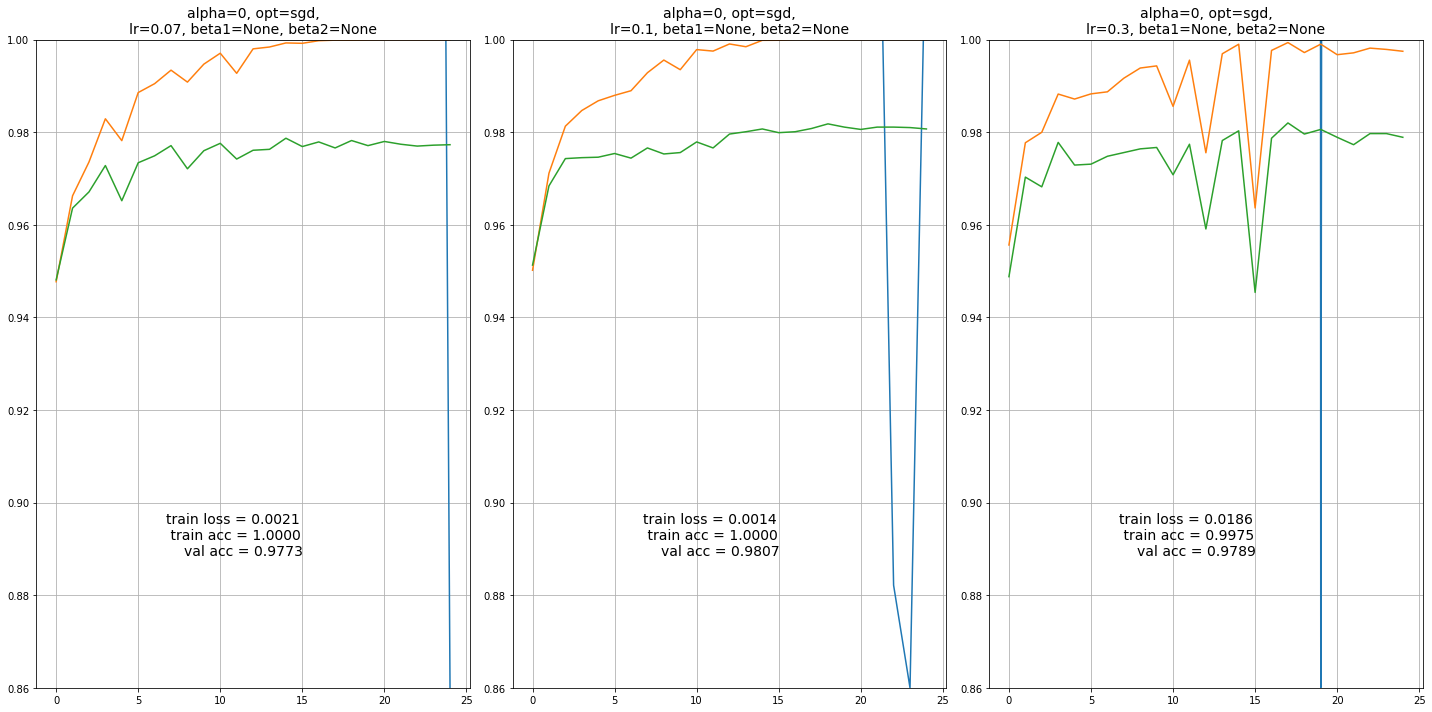

In [39]:
#sgd optimiser

alpha = 0

optimizer = 'sgd'
lrs = [0.07, 0.1, 0.3]
beta1 = None #not needed for sgd
beta2 = None #not needed for sgd

n_epochs = 25

fig = plt.figure(figsize=(20, 10))
i = 0
for lr in lrs:
    i += 1
    loss_train_log, acc_train_log, acc_val_log = build_and_train3(alpha=alpha,
                                          optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2, n_epochs=n_epochs)

    ax = plt.subplot(1, len(lrs), i) 
    display_learning_curve3(ax, loss_train_log, acc_train_log, acc_val_log, alpha=alpha,
                            optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2)



Training with alpha = 0, optimizer = momentum, lr = 0.007, beta1 = 0.8 and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = momentum, lr = 0.01, beta1 = 0.8 and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = momentum, lr = 0.03, beta1 = 0.8 and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = momentum, lr = 0.007, beta1 = 0.9 and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = momentum, lr = 0.01, beta1 = 0.9 and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = momentum, lr = 0.03, beta1 = 0.9 and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = momentum, lr = 0.007, beta1 = 0.95 and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = momentum, lr = 0.01, beta1 = 0.95 and beta2 = None for n_epochs = 25

Training with alpha = 0, optimizer = momentum, lr = 0.03, beta1 = 0.95 and beta2 = None for n_epochs = 25


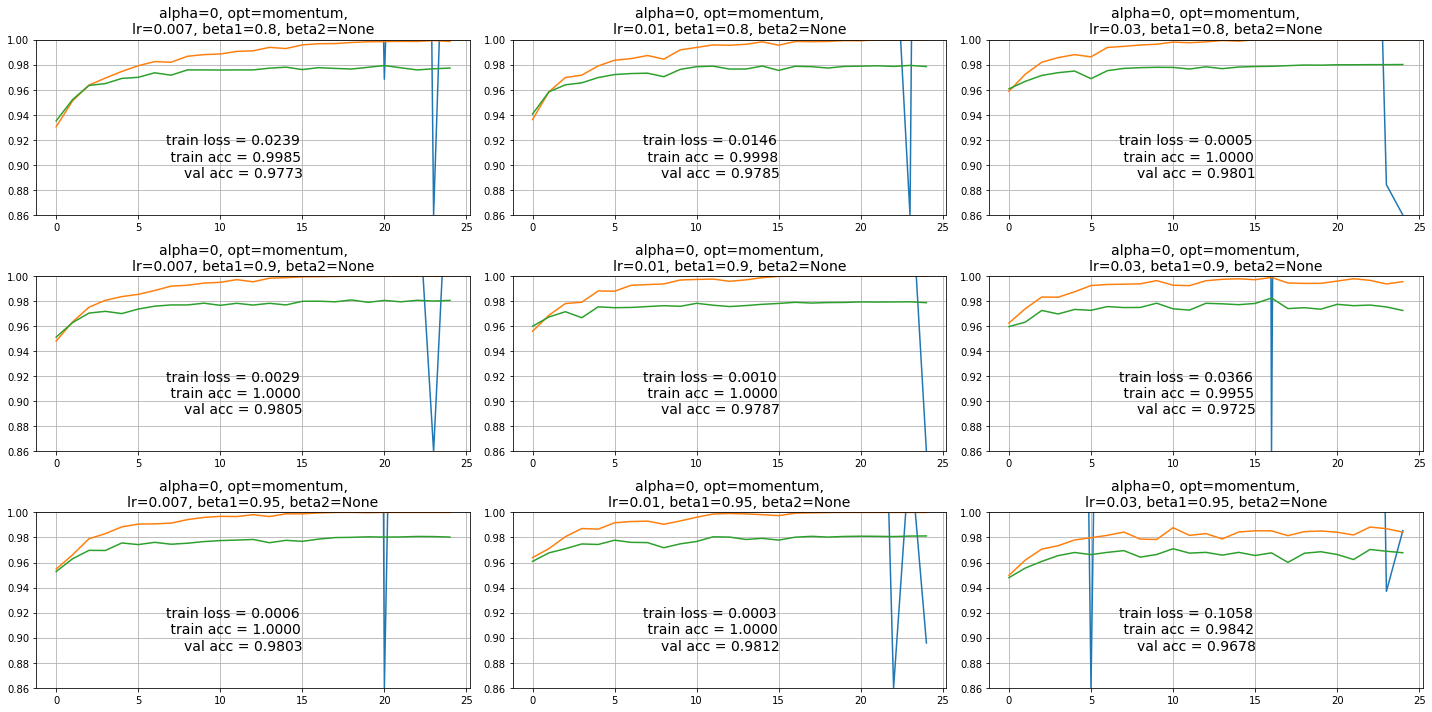

In [40]:
#momentum optimiser, requires beta1 input

alpha = 0
optimizer = 'momentum'
lrs = [0.007, 0.01, 0.03]
beta1s = [0.8, 0.9, 0.95]
beta2 = None

n_epochs = 25

fig = plt.figure(figsize=(20, 10))
i = 0
for beta1, lr in itertools.product(beta1s, lrs):
    i += 1
    loss_train_log, acc_train_log, acc_val_log = build_and_train3(alpha=alpha, optimizer=optimizer,
                                                                lr=lr, beta1=beta1, beta2=beta2, n_epochs=n_epochs)
    ax = plt.subplot(len(beta1s), len(lrs), i)
    display_learning_curve3(ax, loss_train_log, acc_train_log, acc_val_log, alpha=alpha,
                           optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2)


Training with alpha = 0, optimizer = rmsprop, lr = 0.0007, beta1 = None and beta2 = 0.8 for n_epochs = 25

Training with alpha = 0, optimizer = rmsprop, lr = 0.001, beta1 = None and beta2 = 0.8 for n_epochs = 25

Training with alpha = 0, optimizer = rmsprop, lr = 0.003, beta1 = None and beta2 = 0.8 for n_epochs = 25


/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':



Training with alpha = 0, optimizer = rmsprop, lr = 0.0007, beta1 = None and beta2 = 0.9 for n_epochs = 25

Training with alpha = 0, optimizer = rmsprop, lr = 0.001, beta1 = None and beta2 = 0.9 for n_epochs = 25

Training with alpha = 0, optimizer = rmsprop, lr = 0.003, beta1 = None and beta2 = 0.9 for n_epochs = 25

Training with alpha = 0, optimizer = rmsprop, lr = 0.0007, beta1 = None and beta2 = 0.99 for n_epochs = 25

Training with alpha = 0, optimizer = rmsprop, lr = 0.001, beta1 = None and beta2 = 0.99 for n_epochs = 25

Training with alpha = 0, optimizer = rmsprop, lr = 0.003, beta1 = None and beta2 = 0.99 for n_epochs = 25


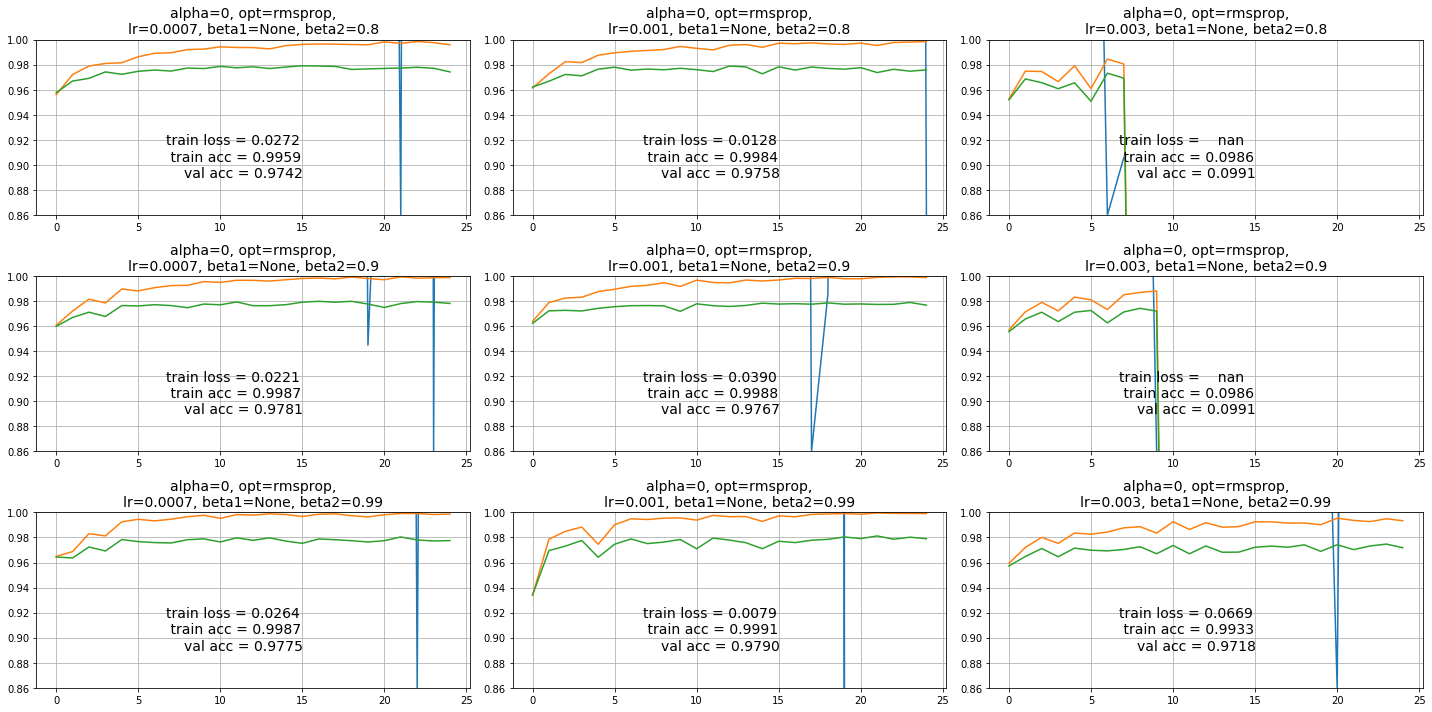

In [41]:
#rmsprop optimiser, requires beta2 input, requires lower learning rate for convergence

alpha=0
optimizer='rmsprop'
lrs = [0.0007, 0.001, 0.003]
beta1 = None
beta2s = [0.8, 0.9, 0.99]

n_epochs = 25

fig = plt.figure(figsize=(20,10))
i = 0
for beta2, lr in itertools.product(beta2s, lrs):
    i += 1
    loss_train_log, acc_train_log, acc_val_log = build_and_train3(alpha=alpha, optimizer=optimizer,
                                                                 lr=lr, beta1=beta1, beta2=beta2, n_epochs=n_epochs)
    ax = plt.subplot(len(beta2s), len(lrs), i)
    display_learning_curve3(ax, loss_train_log, acc_train_log, acc_val_log, alpha=alpha, optimizer=optimizer,
                           lr=lr, beta1=beta1, beta2=beta2)

In [42]:
#adam optimiser 

alpha = 0

optimizer = 'adam'
lrs = [0.000000001, 0.00000001, 0.0000001]
beta1 = 0.90 
beta2 = 0.99 

n_epochs = 25

fig = plt.figure(figsize=(20, 10))
i = 0
for lr in lrs:
    i += 1
    loss_train_log, acc_train_log, acc_val_log = build_and_train3(alpha=alpha,
                                          optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2, n_epochs=n_epochs)

    ax = plt.subplot(1, len(lrs), i) 
    display_learning_curve3(ax, loss_train_log, acc_train_log, acc_val_log, alpha=alpha,
                            optimizer=optimizer, lr=lr, beta1=beta1, beta2=beta2)


Training with alpha = 0, optimizer = adam, lr = 1e-09, beta1 = 0.9 and beta2 = 0.99 for n_epochs = 25


/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: overflow encountered in true_divide
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in true_divide
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in true_divide
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: overflow encountered in true_divide
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in multiply
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in multiply
/Users/charlottefettes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] =

KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

From the above, with the parameters used, the version that performed best on the validation set is the combination of momentum optimiser, 0.01 learning rate, 0.95 beta1 and 0 alpha.

This combination will now be used to build the model and generate predictions on the test set. 

As there are various alternative combinations that could have been used (beta1, beta2, alpha, learning rate), this may not be the overall optimal combination, but from those versions tested, it is the best option found.

In [43]:
alpha = 0
optimizer = 'momentum'
lr = 0.01
beta1 = 0.95
beta2 = None

network_opt = []
network_opt.append(Dense3(train_data.shape[1], 100, alpha=alpha, optimizer=optimizer, learning_rate=lr, beta1=beta1, beta2=beta2))
network_opt.append(ReLU())
network_opt.append(Dense3(100, 200, alpha=alpha, optimizer=optimizer, learning_rate=lr, beta1=beta1, beta2=beta2))
network_opt.append(ReLU())
network_opt.append(Dense3(200, 10, alpha=alpha, optimizer=optimizer, learning_rate=lr, beta1=beta1, beta2=beta2))

train_log_opt = []
val_log_opt = []

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9822


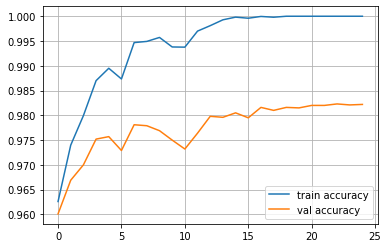

In [44]:
for epoch in range(25):
    mini_batches = iterate_minibatches(train_data, train_labels, 32)
    for mini_batch in mini_batches:
        x_batch = mini_batch[0]
        y_batch = mini_batch[1]
        train(network_opt, x_batch, y_batch)
        
    train_log_opt.append(np.mean(predict(network_opt, train_data) == train_labels))
    val_log_opt.append(np.mean(predict(network_opt, val_data) == val_labels))
    
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log_opt[-1])
    print("Val accuracy:", val_log_opt[-1])
    plt.plot(train_log_opt, label = 'train accuracy')
    plt.plot(val_log_opt, label = 'val accuracy')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

In [45]:
#evaluate performance with test set
from sklearn.metrics import classification_report, confusion_matrix

predictions_opt = predict(network_opt, test_data)

print(classification_report(predictions_opt, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       989
           1       0.99      0.99      0.99      1141
           2       0.98      0.99      0.98      1022
           3       0.98      0.98      0.98      1008
           4       0.98      0.98      0.98       980
           5       0.97      0.99      0.98       879
           6       0.98      0.98      0.98       959
           7       0.98      0.98      0.98      1026
           8       0.98      0.98      0.98       978
           9       0.98      0.97      0.97      1018

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# NN (MLP) with Tensorflow

In [46]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from keras import backend as K


Using TensorFlow backend.


In [47]:
## Load the training set
train_data = np.float32(load_mnist_images('train-images-idx3-ubyte.gz'))
train_labels = np.int32(load_mnist_labels('train-labels-idx1-ubyte.gz'))

## Load the testing set
test_data = np.float32(load_mnist_images('t10k-images-idx3-ubyte.gz'))
test_labels = np.int32(load_mnist_labels('t10k-labels-idx1-ubyte.gz'))

In [48]:
# normalise x
train_data = train_data / 255.
test_data = test_data / 255.

#split into train and validation
train_data, val_data = train_data[:-10000], train_data[-10000:]
train_labels, val_labels = train_labels[:-10000], train_labels[-10000:]

#flatten the data       
train_data = train_data.reshape([train_data.shape[0], -1])
val_data = val_data.reshape([val_data.shape[0], -1])
test_data = test_data.reshape([test_data.shape[0], -1])

In [49]:
# function to clear session/graph if need to rebuild graph or run again to avoid out-of-memory errors
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [50]:
from IPython.display import clear_output, display_html, HTML
import io
import urllib
import base64

def clear_and_display_figure(fig, sleep=0.01):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='jpeg')
    img_data.seek(0)
    uri = 'data:image/jpeg;base64,' + urllib.request.quote(base64.b64encode(img_data.getbuffer()))
    img_data.close()
    clear_output(wait=True)
    display_html(HTML('<img src="' + uri + '">'))
    time.sleep(sleep)

In [51]:
#class for generating simple training curve
class SimpleTrainingCurves(object):
    def __init__(self, loss_name, metric_name):
        self.fig, (self.ax1, self.ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        self.ax1.set_title(loss_name)
        self.ax2.set_title(metric_name)
        self.train_loss_curve, = self.ax1.plot([], [], 'r', label='train', lw=2)
        self.valid_loss_curve, = self.ax1.plot([], [], 'g', label='valid', lw=2)
        self.train_metric_curve, = self.ax2.plot([], [], 'r', label='train', lw=2)
        self.valid_metric_curve, = self.ax2.plot([], [], 'g', label='valid', lw=2)
        self.iter = 0
        self.y_limits_1 = [None, None]
        self.y_limits_2 = [None, None]
        plt.close(self.fig)

    def _update_y_limits(self, limits, *values):
        limits[0] = min(list(values) + ([limits[0]] if limits[0] else []))
        limits[1] = max(list(values) + ([limits[1]] if limits[1] else []))

    def _update_curve(self, curve, value, label):
        x, y = curve.get_data()
        curve.set_data(list(x) + [self.iter], list(y) + [value])
        curve.set_label("{}: {}".format(label, value))

    def _set_y_limits(self, ax, limits):
        spread = limits[1] - limits[0]
        ax.set_ylim(limits[0] - 0.05*spread, limits[1] + 0.05*spread)

    def add(self, train_loss, valid_loss, train_metric, valid_metric):
        self._update_curve(self.train_loss_curve, train_loss, "train")
        self._update_curve(self.valid_loss_curve, valid_loss, "valid")
        self._update_curve(self.train_metric_curve, train_metric, "train")
        self._update_curve(self.valid_metric_curve, valid_metric, "valid")
        self.ax1.set_xlim(0, self.iter)
        self.ax2.set_xlim(0, self.iter)
        self._update_y_limits(self.y_limits_1, train_loss, valid_loss)
        self._update_y_limits(self.y_limits_2, train_metric, valid_metric)
        self._set_y_limits(self.ax1, self.y_limits_1)
        self._set_y_limits(self.ax2, self.y_limits_2)
        clear_and_display_figure(self.fig)
        self.ax1.legend()
        self.ax2.legend()
        self.iter += 1

## Linear model

Here, a linear classifier will be trained with SGD using TensorFlow

In [52]:
#flatten images from 28x28 to 784
train_data_flat = train_data.reshape((train_data.shape[0], -1))
print(train_data_flat.shape)

val_data_flat = val_data.reshape((val_data.shape[0], -1))
print(val_data_flat.shape)

(50000, 784)
(10000, 784)


In [53]:
#convert training labels to one-hot encoded vectors required for cross-entropy
train_labels_oh = keras.utils.to_categorical(train_labels, 10)
val_labels_oh = keras.utils.to_categorical(val_labels, 10)

print(train_labels_oh.shape)
print(val_labels_oh.shape)

(50000, 10)
(10000, 10)


In [54]:
#reset graph if needed
s = reset_tf_session()

In [55]:
#use shared variable for model parameters W (weights) and b (biases)
W = tf.get_variable("W", dtype = tf.float32, shape=(784, 10), trainable=True)
b = tf.get_variable("b", dtype = tf.float32, shape=(10, ))

In [56]:
#use matrix placeholder for input data
input_X = tf.placeholder(tf.float32, shape=(None, 784))
input_y = tf.placeholder(tf.float32, shape=(None, 10))

In [57]:
#compute predictions
#logits for input_X
logits = input_X @ W + b
#apply tf.nn.softmax to logits
probas = tf.nn.softmax(logits)
#apply tf.argmax to find a class index with highest probability
classes = tf.argmax(probas, 1)

#compute loss, where loss is a scalar number - average loss over all objects
#same as calculating cross-entropy on top of probas, but more numerically friendly
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels=input_y))

#use default adam optimiser to get SGD step; optimiser step that minimises loss
step = tf.train.AdamOptimizer().minimize(loss)

In [58]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

#logging progress
simpleTrainingCurves = SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):
    batch_losses = []
    for batch_start in range(0, train_data_flat.shape[0], BATCH_SIZE):
        _, batch_loss = s.run([step, loss], {input_X: train_data_flat[batch_start:batch_start+BATCH_SIZE],
                                            input_y: train_labels_oh[batch_start:batch_start+BATCH_SIZE]})
        #collect batch losses
        batch_losses.append(batch_loss)
    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: val_data_flat, input_y:val_labels_oh})
    train_accuracy = accuracy_score(train_labels, s.run(classes, {input_X:train_data_flat}))
    valid_accuracy = accuracy_score(val_labels, s.run(classes, {input_X: val_data_flat}))
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxNb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgV4X8Nay3hfxV470a58RHRfGd/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhWZb1YftJtovMBCjHqPxo/4J0Wvx6/Zu8T/Dj4hfHPxrd%2BO/GHwvj8M694pbxtrQ0ea%2BW0hibUE0Jb5bC3Z5oFlbyIopCHkAkVpGcgHRwf8FKP2Mv%2BFc%2BK/itrHxWvdE0bwRZWV94ofxP4O1fSbmysryYw2t79lvLWK4ktJZFZUuY42hby3IfCMRyHxu/4Kyfs7/DP4Iap8Y/Aei%2BKvFU2g/EHwv4X13wx/wAILrtjqdgdZ1K1tY7p7OTTmuvK8i4eeBvJ8u8eNLeGQyTxg%2BV6p/wTE%2BMnjv4VePtI8ReBvDejeMfEeh6Po9h4h1X9ovxn43W7tLXWLfUJo5P7dgP2CM%2BSxSKJZjvfDSYyT3/7UP7Bnxp%2BMHxB%2BL/xB8C%2BIfC8cni%2BD4W3nhKz1a%2BuYle/8J%2BI7nWpYbxo7eTyIbgNbwrLGJnXLsY/kVXAPULD/goJ%2By3qPxNsvgzD4n8TR%2BK7zRdP1iXQLv4b69Bc6dp9606QXd%2Bklkp06Hdbyq8l15SxEKJChdN1Hw1/wUw/Yp8W%2BDPFnxC0j4wXCaP4L8EXXjLWL3UPCWq2guPD1ujPNq1is9qjapZqqHE9mJ42LIFYl0DYOh/sh/FD4h/Ez43fEH44L4e0GL40fB3w74QurHwnrtxqMul3Fomupdss89na%2BZGBqsRifYrMUk3Rx4G75u/bG/ZU/ah0f9hj4pfE39pi78AWkPwh/Yp%2BIPgjwvH4C1C8uG15r3SLYz6jdLc20AsVCaRbhLONrgK00hM7bUFAH1n4e/4KS/sZeJtD1jxHp/xauoLPQ00qa%2Bk1TwlqtkzWmpXa2djqEK3FqjXNhLOwUX0Ie1UBnaVUVmHp%2BifF34eeI/ilr/wX0PxD9p8SeFtL0/UNfsI7SbbZwXzXAtd0xTyi7/ZZj5SuZFUIzKqyRlvknUP2Z/EHivQPFPxt/wCCkXi/4Z%2BE/Alv%2Bz3c/DqS48P%2BIJltZtNvZIZLzVbya9gt0sHJgthDbIZxATJ/pEhZcdh/wR88B/F2y/ZHtfj/APtIagb74k/F68j8T%2BK9Qeze3aSEWkFlpq%2BVJ88P/EutLSRomwUlmmyAxbIB9VUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4jpH/AAUY/Y91K716z1P4pXnh5vDnhy58QahJ418I6roMc2k27pHPf2smpWsC31ujyRK0tsZUBljGcuufab2K5ms5YbO6EEzxMsUxj3%2BWxHDbT1wecd6/MTV/%2BCOX7cvxf1bwvrnxu%2BOOhvrfhrwfqFnqHijUPit4m8TjxDrf2zSr611E6XfRQ2Wk20lzpi%2BfYWQCiOTassgVAoB9sv8At/8A7MNr8NG%2BLGseIPFWlaW2uQaNY2eufDLX7DVNTv5kMkMFlptxYpe37SIGdfs8MgZUdgSEYjovAf7VnwP%2BI%2Bv2XhPw54h1SHV7/wAKT%2BJIdI1rwrqWmXaabDd/ZJZZYby3ikgdZ/kMMirL32bea8m%2BJ3wc/bd%2BMTfD342654N%2BFWh/EP4UeOptY8P%2BGbXxxqV/ouuWdxpN3plzHcXz6VDNYzFL2SSN0tbgRmIKfMEjYq/En4Dftwa/8ZfDv7TXgfRvhXaeLL74Yar4L8Y6FqXivUpLDSFuL%2BG6tb%2ByuE04SagYhG6yW8sVoJS4xLFjkA7jSf8Ago3%2ByB4j17wL4W8K/EbVdZ1P4k%2BDdK8W%2BDdO0TwPrN7PeaHqL7LXUZEgtGa1t92PMknEa24ZTN5QYE7Hw1/bc/Zu%2BK/xGufhP4Z8X6tZ6/b6Xc6nDZeJ/BmraIt/Y28iRz3dlLqNrBHfwRvLEHltmkRfMQkgMpPlH7Cn7CXxY/Zh1/4caz488QeGrs%2BDv2UvCPwxv30i5nlZtW0t5muZovMgj3Wrb02MxV22/NGmBXjXw0/4JV/tjeJ/ij4X8TftTfGGz1SLT/AHivwv408TQfF/xJrV54il1exS2/tO10y%2Bhj0/QjlSxtLRSi5UCZxGq0AfUvhP/gov%2ByP410WPxVoPjvXP7DuNV0vT9P8AEt78P9btdK1GXUr2OyspLS%2Bns0tryCW5mijFxBI8IMqFnCsCfS/C3xd%2BHnjX4geKfhd4X8Q/a9c8FyWcfie0S0mC2Ml1B9ogjMrII3doSshRGZkWSMsFEibvmHxx4E%2BIvhX/AIJ7eNPgR/wUM8T/AAq8EeAtB%2BGkWgW3xM8O%2BLbsM06RpbWupPaXVnAmmzLMLeSGCO4umM5REcnaG7X/AIJX/D74seG/2RNK%2BKv7RVglv8TvixfS%2BOviJClu0X2e/v1jMNpsb5k%2By2MdlZ7TkgWuDQB9G0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRR

## MLP with hidden layers

Instead of coding a dense layer with matrix mulitplication by hand, which will create all necessary variables automatically.

In [59]:
#here, defining MLP with 2 hidden layers

#create 2 dense layers
hidden1 = tf.layers.dense(input_X, 256, activation = tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, 256, activation = tf.nn.sigmoid)
logits = tf.layers.dense(hidden2, 10)

probas = tf.nn.softmax(logits)
classes = tf.argmax(probas, 1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = input_y))
step = tf.train.AdamOptimizer().minimize(loss)

s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

#as above
simpleTrainingCurves = SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):
    batch_losses = []
    for batch_start in range(0, train_data_flat.shape[0], BATCH_SIZE):
        _, batch_loss = s.run([step, loss], {input_X: train_data_flat[batch_start:batch_start+BATCH_SIZE],
                                            input_y: train_labels_oh[batch_start:batch_start+BATCH_SIZE]})
        #collect batch losses
        batch_losses.append(batch_loss)
    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: val_data_flat, input_y:val_labels_oh})
    train_accuracy = accuracy_score(train_labels, s.run(classes, {input_X:train_data_flat}))
    valid_accuracy = accuracy_score(val_labels, s.run(classes, {input_X: val_data_flat}))
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxNb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgV4X8Nay3hfxV470a58RHRfGd/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhWZb1YftJtovMBCjHqPxo/4J0Wvx6/Zu8T/Dj4hfHPxrd%2BO/GHwvj8M694pbxtrQ0ea%2BW0hibUE0Jb5bC3Z5oFlbyIopCHkAkVpGcgHRwf8FKP2Mv%2BFc%2BK/itrHxWvdE0bwRZWV94ofxP4O1fSbmysryYw2t79lvLWK4ktJZFZUuY42hby3IfCMRyHxu/4Kyfs7/DP4Iap8Y/Aei%2BKvFU2g/EHwv4X13wx/wAILrtjqdgdZ1K1tY7p7OTTmuvK8i4eeBvJ8u8eNLeGQyTxg%2BV6p/wTE%2BMnjv4VePtI8ReBvDejeMfEeh6Po9h4h1X9ovxn43W7tLXWLfUJo5P7dgP2CM%2BSxSKJZjvfDSYyT3/7UP7Bnxp%2BMHxB%2BL/xB8C%2BIfC8cni%2BD4W3nhKz1a%2BuYle/8J%2BI7nWpYbxo7eTyIbgNbwrLGJnXLsY/kVXAPULD/goJ%2By3qPxNsvgzD4n8TR%2BK7zRdP1iXQLv4b69Bc6dp9606QXd%2Bklkp06Hdbyq8l15SxEKJChdN1Hw1/wUw/Yp8W%2BDPFnxC0j4wXCaP4L8EXXjLWL3UPCWq2guPD1ujPNq1is9qjapZqqHE9mJ42LIFYl0DYOh/sh/FD4h/Ez43fEH44L4e0GL40fB3w74QurHwnrtxqMul3Fomupdss89na%2BZGBqsRifYrMUk3Rx4G75u/bG/ZU/ah0f9hj4pfE39pi78AWkPwh/Yp%2BIPgjwvH4C1C8uG15r3SLYz6jdLc20AsVCaRbhLONrgK00hM7bUFAH1n4e/4KS/sZeJtD1jxHp/xauoLPQ00qa%2Bk1TwlqtkzWmpXa2djqEK3FqjXNhLOwUX0Ie1UBnaVUVmHp%2BifF34eeI/ilr/wX0PxD9p8SeFtL0/UNfsI7SbbZwXzXAtd0xTyi7/ZZj5SuZFUIzKqyRlvknUP2Z/EHivQPFPxt/wCCkXi/4Z%2BE/Alv%2Bz3c/DqS48P%2BIJltZtNvZIZLzVbya9gt0sHJgthDbIZxATJ/pEhZcdh/wR88B/F2y/ZHtfj/APtIagb74k/F68j8T%2BK9Qeze3aSEWkFlpq%2BVJ88P/EutLSRomwUlmmyAxbIB9VUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4jpH/AAUY/Y91K716z1P4pXnh5vDnhy58QahJ418I6roMc2k27pHPf2smpWsC31ujyRK0tsZUBljGcuufab2K5ms5YbO6EEzxMsUxj3%2BWxHDbT1wecd6/MTV/%2BCOX7cvxf1bwvrnxu%2BOOhvrfhrwfqFnqHijUPit4m8TjxDrf2zSr611E6XfRQ2Wk20lzpi%2BfYWQCiOTassgVAoB9sv8At/8A7MNr8NG%2BLGseIPFWlaW2uQaNY2eufDLX7DVNTv5kMkMFlptxYpe37SIGdfs8MgZUdgSEYjovAf7VnwP%2BI%2Bv2XhPw54h1SHV7/wAKT%2BJIdI1rwrqWmXaabDd/ZJZZYby3ikgdZ/kMMirL32bea8m%2BJ3wc/bd%2BMTfD342654N%2BFWh/EP4UeOptY8P%2BGbXxxqV/ouuWdxpN3plzHcXz6VDNYzFL2SSN0tbgRmIKfMEjYq/En4Dftwa/8ZfDv7TXgfRvhXaeLL74Yar4L8Y6FqXivUpLDSFuL%2BG6tb%2ByuE04SagYhG6yW8sVoJS4xLFjkA7jSf8Ago3%2ByB4j17wL4W8K/EbVdZ1P4k%2BDdK8W%2BDdO0TwPrN7PeaHqL7LXUZEgtGa1t92PMknEa24ZTN5QYE7Hw1/bc/Zu%2BK/xGufhP4Z8X6tZ6/b6Xc6nDZeJ/BmraIt/Y28iRz3dlLqNrBHfwRvLEHltmkRfMQkgMpPlH7Cn7CXxY/Zh1/4caz488QeGrs%2BDv2UvCPwxv30i5nlZtW0t5muZovMgj3Wrb02MxV22/NGmBXjXw0/4JV/tjeJ/ij4X8TftTfGGz1SLT/AHivwv408TQfF/xJrV54il1exS2/tO10y%2Bhj0/QjlSxtLRSi5UCZxGq0AfUvhP/gov%2ByP410WPxVoPjvXP7DuNV0vT9P8AEt78P9btdK1GXUr2OyspLS%2Bns0tryCW5mijFxBI8IMqFnCsCfS/C3xd%2BHnjX4geKfhd4X8Q/a9c8FyWcfie0S0mC2Ml1B9ogjMrII3doSshRGZkWSMsFEibvmHxx4E%2BIvhX/AIJ7eNPgR/wUM8T/AAq8EeAtB%2BGkWgW3xM8O%2BLbsM06RpbWupPaXVnAmmzLMLeSGCO4umM5REcnaG7X/AIJX/D74seG/2RNK%2BKv7RVglv8TvixfS%2BOviJClu0X2e/v1jMNpsb5k%2By2MdlZ7TkgWuDQB9G0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRR

In [60]:
test_data_flat = test_data.reshape((test_data.shape[0], -1))

In [61]:
#evaluate performance with test set
from sklearn.metrics import classification_report, confusion_matrix

predictions = s.run(classes, {input_X: test_data_flat})

print(classification_report(predictions, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       987
           1       0.99      0.99      0.99      1126
           2       0.98      0.97      0.98      1046
           3       0.98      0.97      0.97      1029
           4       0.98      0.98      0.98       984
           5       0.95      0.99      0.97       860
           6       0.98      0.98      0.98       952
           7       0.98      0.97      0.98      1033
           8       0.98      0.95      0.97       999
           9       0.96      0.98      0.97       984

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# NN (MLP) with Kera

In [62]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from keras.layers import Dense, Activation
from keras.models import Sequential

In [63]:
## Load the training set
train_data = np.float32(load_mnist_images('train-images-idx3-ubyte.gz'))
train_labels = np.int32(load_mnist_labels('train-labels-idx1-ubyte.gz'))

## Load the testing set
test_data = np.float32(load_mnist_images('t10k-images-idx3-ubyte.gz'))
test_labels = np.int32(load_mnist_labels('t10k-labels-idx1-ubyte.gz'))

In [64]:
# normalise x
train_data = train_data / 255.
test_data = test_data / 255.

#split into train and validation
train_data, val_data = train_data[:-10000], train_data[-10000:]
train_labels, val_labels = train_labels[:-10000], train_labels[-10000:]

#flatten the data       
train_data = train_data.reshape([train_data.shape[0], -1])
val_data = val_data.reshape([val_data.shape[0], -1])
test_data = test_data.reshape([test_data.shape[0], -1])

In [65]:
#flatten images
train_data_flat = train_data.reshape((train_data.shape[0], -1))
val_data_flat = val_data.reshape((val_data.shape[0], -1))

In [66]:
#one-hot encode labels
train_labels_oh = keras.utils.to_categorical(train_labels, 10)
val_labels_oh = keras.utils.to_categorical(val_labels, 10)

In [67]:
#build model with keras

#clear graph
s = reset_tf_session()

#feedforward network without loops; for regularisation, add in  to Dense
#e.g. kernel_regularizer=regularizers.l2(alpha) (from keras import regularizers)
#also activity_regularizer an additionl potential parameter
model = Sequential()
model.add(Dense(256, input_shape=(784,)))
model.add(Activation('sigmoid')) #alternative activations e.g. tanh, elu, selu, relu etc.
model.add(Dense(256))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [68]:
#summarise layers and parameter count
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
________________________________________________

In [69]:
#compile model specifying loss and optimiser; accuracy metrics reports accuracy during training
model.compile(loss='categorical_crossentropy', #alternatives to minimise e.g. mean_squared_error; for binary binary_crossentropy
             optimizer='adam', #alternatives: rmsprop, nesterov_momentum, adagrad etc
             metrics=['accuracy']) #alternatives e.g. mae

In [70]:
#fit model
model.fit(train_data_flat,
         train_labels_oh,
         batch_size=512,
         epochs=40,
         validation_data=(val_data_flat, val_labels_oh),
         verbose=0)

In [71]:
#evaluate performance with test set
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_classes(test_data)

print(classification_report(predictions, test_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       984
           1       0.99      0.99      0.99      1139
           2       0.98      0.98      0.98      1037
           3       0.98      0.98      0.98      1016
           4       0.98      0.98      0.98       980
           5       0.97      0.98      0.98       880
           6       0.98      0.98      0.98       954
           7       0.98      0.98      0.98      1025
           8       0.97      0.97      0.97       980
           9       0.97      0.98      0.97      1005

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



The Mulitlayer Perceptron Neural Network achieved the highest level of accuracy on predicting the test set labels, with 98%.